In [1]:
# import requests

# url = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1"
# response = requests.get(url)

# # Specify the path where you want to save the dataset
# filepath = "/home/cminds/CMInDS/Uddeshya/GNR650/Dataset"

# with open(filepath, 'wb') as file:
#     file.write(response.content)

In [3]:
# import zipfile

# with zipfile.ZipFile('/home/cminds/CMInDS/Uddeshya/GNR650/Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/home/cminds/CMInDS/Uddeshya/GNR650/data/Eurosat')


In [3]:
import os
import cv2
import numpy as np




def load_images_from_folder(folder_path):
    """
    Load images from a specific folder.

    Args:
    - folder_path (str): Path to the specific folder to load images from.

    Returns:
    - List of images.
    """
    images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more extensions if needed
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)

    return images

# Example usage:
base_folder = "/home/cminds/CMInDS/Uddeshya/GNR650/data/Eurosat/EuroSAT_RGB"
all_images = []

# Create a dictionary for folder (class) name to numeric label mapping
folder_names = [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))]
label_map = {folder_name: idx for idx, folder_name in enumerate(folder_names)}

# Iterate over all folders in the base directory
all_labels = []  # To store the labels corresponding to each image

# Iterate over all folders in the base directory
for folder_name in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder_name)
    if os.path.isdir(folder_path):  # Check if it's a directory
        images_in_folder = load_images_from_folder(folder_path)
        all_images.extend(images_in_folder)
        all_labels.extend([label_map[folder_name]] * len(images_in_folder))

all_images = np.array(all_images)
all_labels = np.array(all_labels)





In [4]:
all_images.shape,all_labels.shape

((27000, 64, 64, 3), (27000,))

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (e.g., convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to the input size expected by ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

dataset = CustomImageDataset(all_images, all_labels, transform=transform)


In [6]:
import torch

SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [7]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))  # Use 80% of data for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle the test set


In [9]:
def count_images_per_label(dataset):
    label_counts = {}
    for _, label in dataset:
        label = label.item()  # Convert tensor to a Python integer, if it's a tensor
        label_counts[label] = label_counts.get(label, 0) + 1
    return label_counts

train_label_counts = count_images_per_label(train_dataset)
test_label_counts = count_images_per_label(test_dataset)


In [10]:
train_label_counts,test_label_counts

({2: 2031,
  0: 1974,
  7: 1994,
  6: 2400,
  5: 2404,
  3: 1982,
  8: 2403,
  1: 1586,
  9: 2439,
  4: 2387},
 {2: 469,
  9: 561,
  1: 414,
  0: 526,
  5: 596,
  6: 600,
  7: 506,
  4: 613,
  8: 597,
  3: 518})

In [11]:
import matplotlib.pyplot as plt

# Load the image
image = plt.imread('/home/cminds/CMInDS/Uddeshya/GNR650/data/Eurosat/EuroSAT_RGB/AnnualCrop/AnnualCrop_1.jpg')

# Print the shape of the image
height, width, channels = image.shape
print(f"Image dimensions: Width: {width}, Height: {height}")
print(f"Number of channels: {channels}") # Typically 3 for RGB, 4 for RGBA


Image dimensions: Width: 64, Height: 64
Number of channels: 3


In [12]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
/bin/bash: /home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2


In [24]:
import torchinfo
from torchinfo import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
# set_seeds()
# pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output


In [37]:
num_classes = len(label_map)
pretrained_vit.heads = torch.nn.Linear(in_features=768, out_features=num_classes).to(device)
# pretrained_vit # uncomment for model output

In [38]:
# Freeze the first 11 encoder layers
for i in range(11):
    for param in pretrained_vit.encoder.layers[i].parameters():
        param.requires_grad = False


In [39]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              Partial
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [3

In [40]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.parameters(), lr=1e-4)


In [41]:

num_epochs = 3

for epoch in range(num_epochs):
    pretrained_vit.train()
    total_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = pretrained_vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/3], Loss: 0.2552
Epoch [2/3], Loss: 0.0859
Epoch [3/3], Loss: 0.0541


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, num_epochs=10, lr=1e-4):
    """
    Trains the given model on the provided data and plots the training loss curve.

    Args:
    - model: The model to train.
    - train_loader: DataLoader for the training data.
    - num_epochs: Number of epochs to train for.
    - lr: Learning rate for the optimizer.

    Returns:
    - model: The trained model.
    """
    # Set up the criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # List to store losses for each epoch
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Plot the training loss curve
    plt.plot(epoch_losses, '-o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return model

# Example usage:
# pretrained_vit = train_model(pretrained_vit, train_loader, num_epochs=10)


Test Accuracy: 96.61%


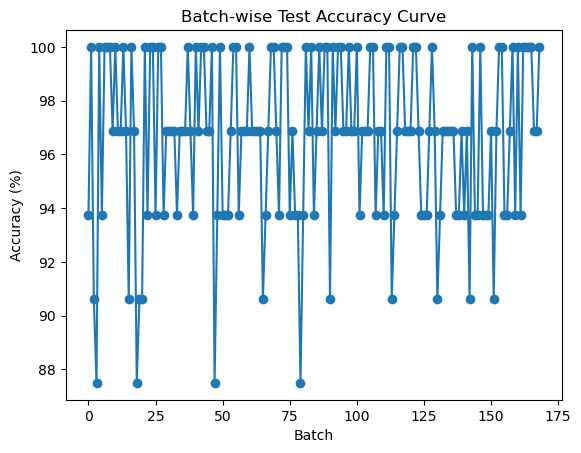

In [42]:
def test_model(model, test_loader):
    """
    Evaluates the given model on the provided test data and plots the accuracy curve.

    Args:
    - model: The model to evaluate.
    - test_loader: DataLoader for the test data.

    Returns:
    - accuracy: Test accuracy of the model.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    # List to store accuracies for each batch
    batch_accuracies = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)
            batch_accuracies.append(batch_accuracy)

    # Calculate overall accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Plot the batch-wise accuracy curve
    plt.plot(batch_accuracies, '-o')
    plt.title('Batch-wise Test Accuracy Curve')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.show()

    return accuracy

# Example usage:
test_accuracy = test_model(pretrained_vit, test_loader)


In [52]:
print(pretrained_vit)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [55]:
class IntermediateLayerGetter(torch.nn.Module):
    def __init__(self, model, layer_num=4):
        super(IntermediateLayerGetter, self).__init__()
        self.model = model
        self.layer_num = layer_num

    def forward(self, x):
        # Pass through the conv_proj layer
        x = self.model.conv_proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # Convert to NxCx(HxW)

        # Here, we might need to add cls_token and positional embedding, but since they're not directly
        # mentioned in the provided structure, I'll skip this step for now.

        # Pass through the specified number of EncoderBlock layers
        for i in range(self.layer_num):
            x = self.model.encoder.layers[i](x)
        
        return x




In [56]:
# For demonstration, take one batch from test_loader
images, _ = next(iter(test_loader))
sample_image = images[0].unsqueeze(0).to(device)  
layer_num = 4  # Change this to visualize different layers
model_intermediate = IntermediateLayerGetter(pretrained_vit, layer_num=layer_num).to(device)
intermediate_output = model_intermediate(sample_image)


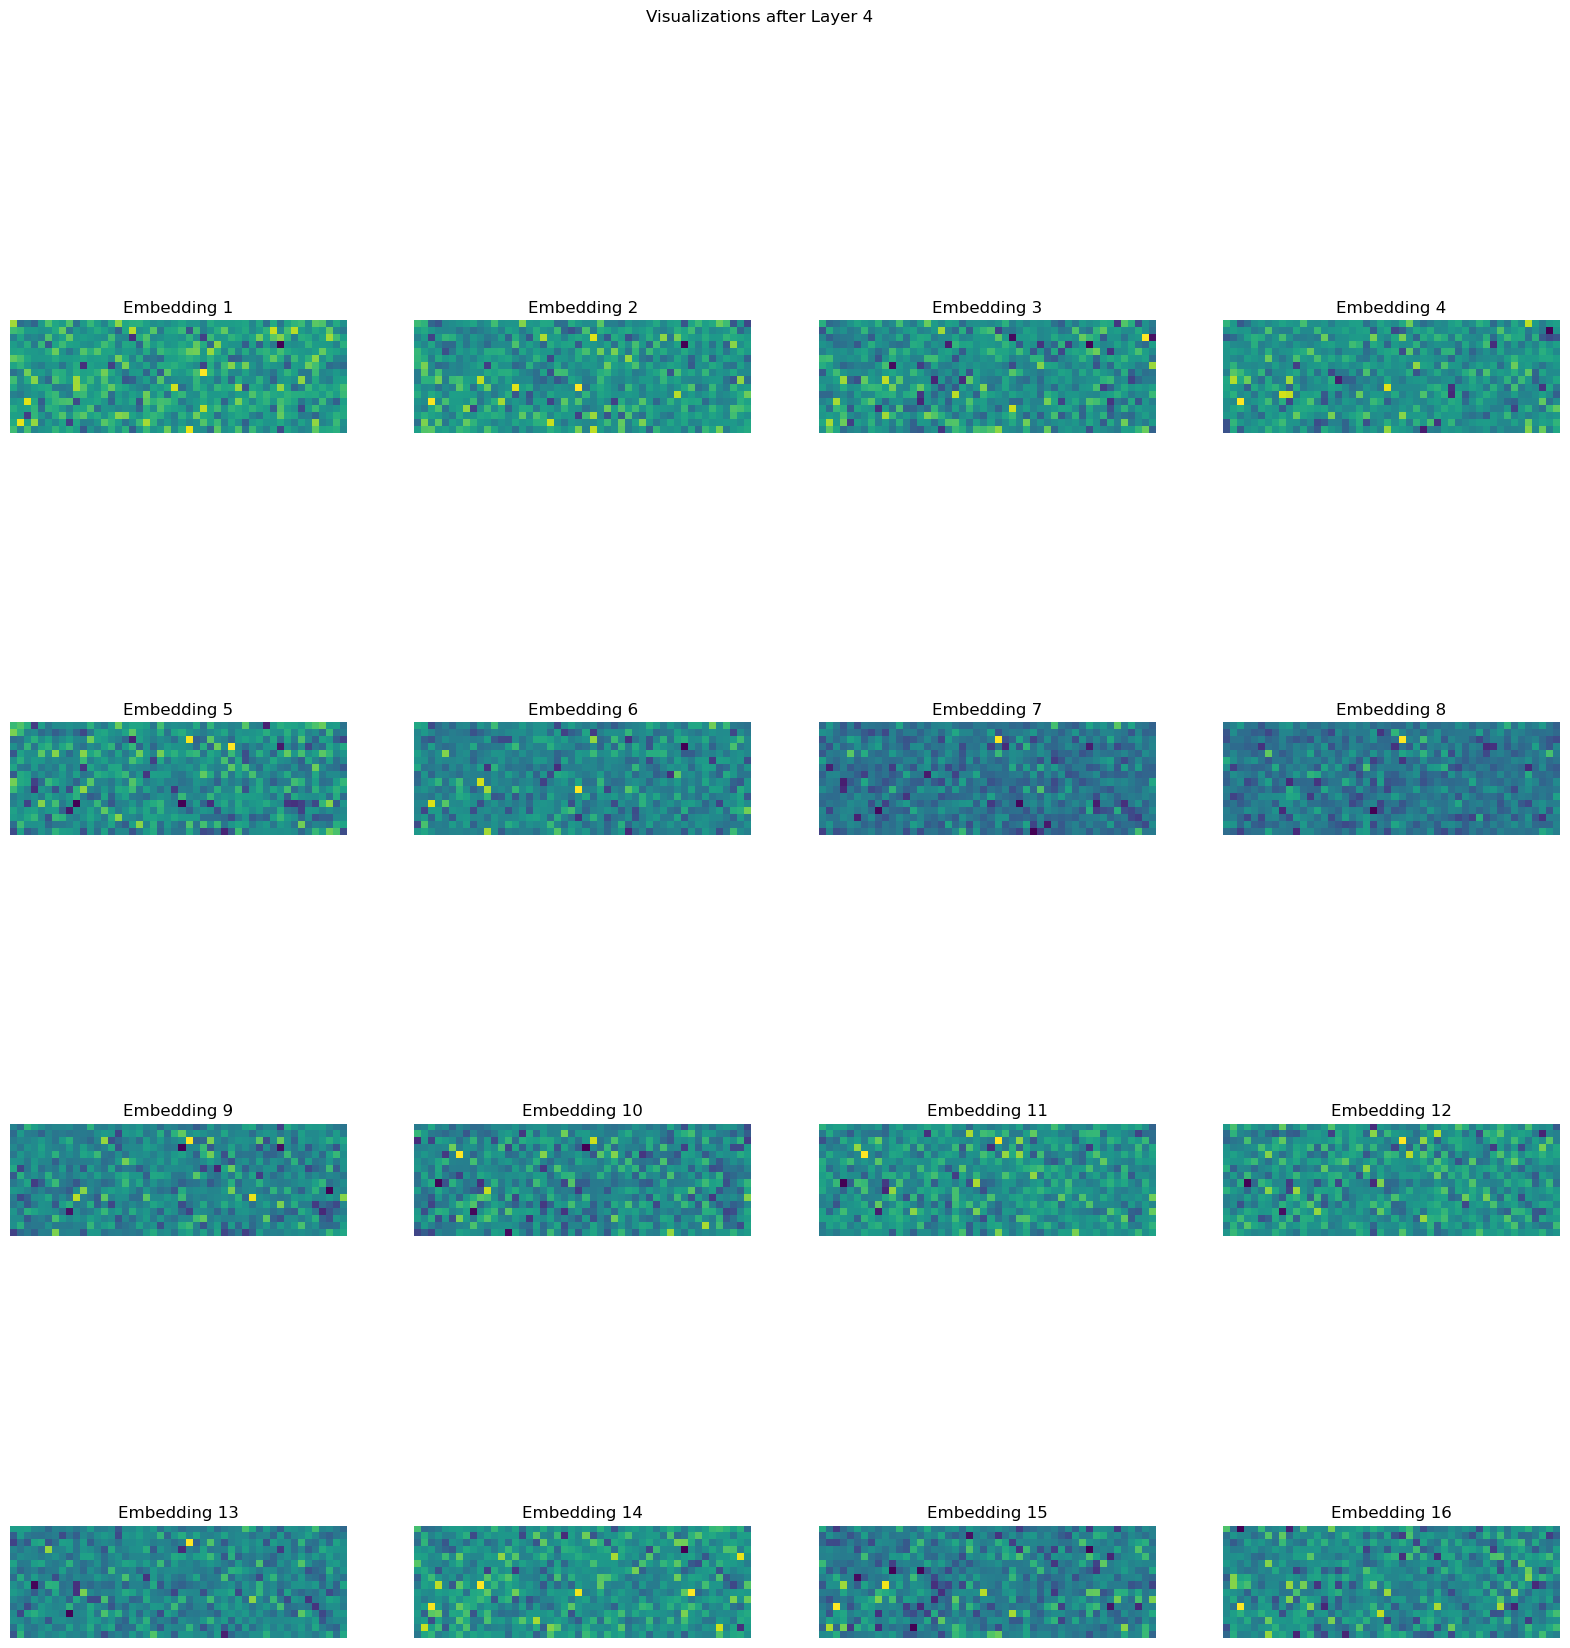

In [57]:
import matplotlib.pyplot as plt

def visualize_intermediate_output(output, layer_num):
    plt.figure(figsize=(20, 20))
    
    # Consider only a subset of embeddings for visualization for clarity
    num_embeddings_to_show = min(16, output.shape[1] - 1)  # -1 to exclude the CLS token

    for i in range(num_embeddings_to_show):
        plt.subplot(4, 4, i+1)
        plt.imshow(output[0, i+1].detach().cpu().numpy().reshape(16, 48), cmap='viridis')  # reshape based on the embedding size
        plt.axis('off')
        plt.title(f'Embedding {i+1}')

    plt.suptitle(f'Visualizations after Layer {layer_num}')
    plt.show()

visualize_intermediate_output(intermediate_output, layer_num)
